In [117]:
import os
import codecs
import re

In [118]:
import numpy as np
import pandas as pd

In [119]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [120]:
from sklearn.model_selection import train_test_split

In [121]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [122]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [123]:
from tqdm import tqdm

In [124]:
np.random.seed(0)

In [125]:
languages = set(['EN', 'JP'])
data_train = {language: None for language in languages}
data_validation = {language: None for language in languages}
emb_matrix = {language: None for language in languages}

In [126]:
dim_seq = {language: None for language in languages}
dim_vocab = {language: None for language in languages}
dim_emb =  {language: 300 for language in languages}
tokenizer = {language: None for language in languages}

In [127]:
detokenizer = {language: None for language in languages}

In [128]:
# Data Preparation

In [129]:
def tokenize(lines):
    tokenizer = Tokenizer(filters="")
    whole_texts = []
    for line in lines:
        whole_texts.append("<s> " + line.strip() + " </s>")
        
    tokenizer.fit_on_texts(whole_texts)
    
    return tokenizer.texts_to_sequences(whole_texts), tokenizer

In [130]:
#path_input = './Data/100/input/'
path_input = '/root/userspace/private/FinalExam/Data/040/input/'

In [131]:
files = os.listdir(path_input)

df = pd.DataFrame()

for i, file in enumerate(files):
    print('{0:02d}/{1:02d}: {2}'.format(i+1, len(files), file))
    
    if re.match('\..*', file):
        print('Incorrect file: {0}\n'.format(file))
        continue
    elif os.path.isdir(path_input + file):
        print('Directory {0}\n'.format(file))
        continue
    
    print('Loading corpus data')
    df_claims = pd.read_csv(path_input + file)
    
    print('\n')
    print(df_claims.info())
    print('\n')
    
    print('Concatenating data frame')
    df = pd.concat([df, df_claims])
    print('Concatenating data frame is finished\n')

01/03: corpus_01.csv
Loading corpus data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15767 entries, 0 to 15766
Data columns (total 5 columns):
id_doc       15767 non-null object
id_claim     15767 non-null int64
claim_JP     15767 non-null object
claim_EP     15767 non-null object
length_EP    15767 non-null int64
dtypes: int64(2), object(3)
memory usage: 616.0+ KB
None


Concatenating data frame
Concatenating data frame is finished

02/03: wvec
Directory wvec

03/03: corpus_02.csv
Loading corpus data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10514 entries, 0 to 10513
Data columns (total 5 columns):
id_doc       10514 non-null object
id_claim     10514 non-null int64
claim_JP     10514 non-null object
claim_EP     10514 non-null object
length_EP    10514 non-null int64
dtypes: int64(2), object(3)
memory usage: 410.8+ KB
None


Concatenating data frame
Concatenating data frame is finished



In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26281 entries, 0 to 10513
Data columns (total 5 columns):
id_doc       26281 non-null object
id_claim     26281 non-null int64
claim_JP     26281 non-null object
claim_EP     26281 non-null object
length_EP    26281 non-null int64
dtypes: int64(2), object(3)
memory usage: 1.2+ MB


In [133]:
df['length_JP'] = df['claim_JP'].map(len)
# df['length_EP'] = df['claim_EP'].map(len)

In [134]:
df['length_JP'].describe()

count    26281.000000
mean       105.197633
std         37.116396
min         19.000000
25%         76.000000
50%        101.000000
75%        130.000000
max        325.000000
Name: length_JP, dtype: float64

In [135]:
df['length_EP'].describe()

count    26281.000000
mean       190.128762
std         69.140710
min         37.000000
25%        134.000000
50%        182.000000
75%        241.000000
max        351.000000
Name: length_EP, dtype: float64

In [136]:
df = df[df['length_EP'] < df['length_EP'].describe()['75%']]

In [137]:
df = df[df['length_JP'] < df['length_JP'].describe()['75%']]

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14631 entries, 0 to 10513
Data columns (total 6 columns):
id_doc       14631 non-null object
id_claim     14631 non-null int64
claim_JP     14631 non-null object
claim_EP     14631 non-null object
length_EP    14631 non-null int64
length_JP    14631 non-null int64
dtypes: int64(3), object(3)
memory usage: 800.1+ KB


In [139]:
df['length_JP'].describe()

count    14631.000000
mean        78.079694
std         18.011410
min         19.000000
25%         65.000000
50%         79.000000
75%         93.000000
max        107.000000
Name: length_JP, dtype: float64

In [140]:
df['length_EP'].describe()

count    14631.000000
mean       141.673775
std         38.282663
min         37.000000
25%        113.000000
50%        140.000000
75%        169.000000
max        240.000000
Name: length_EP, dtype: float64

In [141]:
df_columns = {'EN': 'claim_EP', 'JP': 'claim_JP'}

In [142]:
for language in languages:
    data_train[language], tokenizer[language] = tokenize(df[df_columns[language]].tolist())
    dim_vocab[language] = len(tokenizer[language].word_index) + 1
    print('{0} vocab size: {1}'.format(language, dim_vocab[language]))

EN vocab size: 7434
JP vocab size: 6171


In [143]:
data_train['EN'], data_validation['EN'], data_train['JP'], data_validation['JP'] = train_test_split(
                                                                                       data_train['EN'],
                                                                                       data_train['JP'],
                                                                                       test_size=0.01,
                                                                                       random_state=42
                                                                                   )

In [144]:
for language in languages:
    data_train[language] = pad_sequences(data_train[language], padding='post')
    dim_seq[language] = len(data_train[language][0])
    print('Dim {0} sequence: {1}'.format(language, dim_seq[language]))

Dim EN sequence: 55
Dim JP sequence: 50


In [145]:
# Creating embedding matrix

In [146]:
#path_input_wvec = {'EN': 'Data/100/input/wvec/EN/',
#                   'JP': 'Data/100/input/wvec/JP/'}
path_input_wvec = {'EN': '/root/userspace/private/FinalExam/Data/040/input/wvec/EN/',
                   'JP': '/root/userspace/private/FinalExam/Data/040/input/wvec/JP/'}

In [147]:
for language in languages:
    print('Extracting {0} emb vectors'.format(language))
    
    emb_matrix[language] = np.zeros(shape=(dim_vocab[language], dim_emb[language]), dtype=np.float32)
    
    files = os.listdir(path_input_wvec[language])
    for file in files:
        fin = codecs.open(path_input_wvec[language]+file, 'r', 'utf-8')
        for line in fin:
            tokens = line.rstrip().split(' ')
            if tokens[0] in tokenizer[language].word_index.keys():
                emb_matrix[language][tokenizer[language].word_index[tokens[0]]] = tokens[1:]

Extracting EN emb vectors
Extracting JP emb vectors


In [148]:
vector_bos = np.zeros(shape=(dim_emb[language]), dtype=np.float32)
vector_bos[0] = 1.0 
vector_eos = np.zeros(shape=(dim_emb[language]), dtype=np.float32)
vector_eos[dim_emb[language]-1] = 1.0 

for language in languages:
    emb_matrix[language][tokenizer[language].word_index['<s>']] = vector_bos
    emb_matrix[language][tokenizer[language].word_index['</s>']] = vector_eos

In [149]:
print(tokenizer['JP'].word_index['<s>'])
print(tokenizer['JP'].word_index['</s>'])

7
8


In [150]:
# Building a model

In [151]:
from keras.models import Model
from keras import backend as K

In [152]:
K.clear_session()

In [153]:
def show_graph(model):
    return model_to_dot(model).create(prog='dot', format='svg')

In [154]:
class Generator(object):
    def __init__(self,
                 dim_input_seq,
                 dim_input_vocab,
                 dim_output_seq,
                 dim_output_vocab,
                 dim_emb,
                 dim_hid, 
                 dim_att,
                 emb_matrix_input,
                 emb_matrix_output):

        self.dim_input_seq = dim_input_seq
        self.dim_input_vocab = dim_input_vocab
        
        self.dim_output_seq = dim_output_seq
        self.dim_output_vocab = dim_output_vocab
        
        self.dim_emb = dim_emb
        self.dim_hid = dim_hid
        self.dim_att = dim_att
        
        self.emb_matrix_input = emb_matrix_input
        self.emb_matrix_output = emb_matrix_output
        
        # Model
        self.model = None
                
        # Encoder 
        self._num_encoder_bidirectional_layers = 2
        
        ## Layer
        self._encoder_inputs = None
        
        ## Tensor
        self._encoded_seq = None
        self._encoder_states = []
        
        # Decoder
        self._num_decoder_RNN_layers = 2
        
        ## Layer
        self._decoder_embedding = None
        self._decoder_lstm = []
        self._decoder_dense = None

        # Attension
        ## Layer
        self._attention_score_dense = None
        self._attention_dense = None
        
        # Output
        ## Layer
        self._output_dense = None
        
    def inference(self):
        from keras.layers import Input, Embedding, LSTM, Dense, Activation
        from keras.layers import concatenate, add, dot
        from keras.layers import Lambda
        
        # Encoder
        ## Input Layer
        self._encoder_inputs = Input(shape=(self.dim_input_seq,))
        
        ## Embedding Layer
        seq_embedded = Embedding(self.dim_input_vocab,
                                 self.dim_emb,
                                 weights=[self.emb_matrix_input],
                                 mask_zero=True,
                                 trainable=False)(self._encoder_inputs) # (dim_seq_input,)->(dim_seq_input, dim_emb)
        
        encoded_seq_fwd = Lambda(lambda x: x)(seq_embedded)
        encoded_seq_bwd = Lambda(lambda x: x)(seq_embedded)
       
        ## LSTM Layer
        for i in range(self._num_encoder_bidirectional_layers):
            # (dim_input_seq, dim_emb)->(dim_input_seq, dim_hid)
            encoded_seq_fwd, *encoder_states_fwd = LSTM(self.dim_hid, return_sequences=True, return_state=True)(encoded_seq_fwd)
            encoded_seq_bwd, *encoder_states_bwd = LSTM(self.dim_hid, return_sequences=True, return_state=True, go_backwards=True)(encoded_seq_bwd)
            
            self._encoder_states.append([add([encoder_states_fwd[j], encoder_states_bwd[j]]) for j in range(len(encoder_states_fwd))])
            
        self._encoded_seq = add([encoded_seq_fwd, encoded_seq_bwd])
        
        # Decoder
        ## Instance
        for i in range(self._num_decoder_RNN_layers):
            self._decoder_lstm.append(LSTM(self.dim_hid, return_sequences=True, return_state=True))
        
        ## Input Layer
        decoder_inputs = Input(shape=(self.dim_output_seq,))

        ## Embedding Layer
        ## (dim_output_seq,)->(dim_output_seq, dim_emb)
        decoded_seq = Embedding(self.dim_output_vocab,
                                self.dim_emb,
                                weights=[self.emb_matrix_output],
                                trainable=False)(decoder_inputs)
        
        ## LSTM Layer
        for i in range(self._num_decoder_RNN_layers):
            # (dim_output_seq, dim_emb)->(dim_output_seq, dim_hid)
            decoded_seq, _, _ = self._decoder_lstm[i](decoded_seq, initial_state=self._encoder_states[i])
        
        # Attention
        ## Instance
        self._attention_score_dense = Dense(self.dim_hid)
        self._attention_dense = Dense(self.dim_att, activation='tanh')
        
        ## Attention
        ## (dim_output_seq, dim_hid) -> (dim_output_seq, dim_hid)
        score = self._attention_score_dense(decoded_seq)
        
        ## [(dim_output_seq, dim_hid), (dim_input_seq, dim_hid)] -> (dim_output_seq, dim_input_seq)
        score = dot([score, self._encoded_seq], axes=(2,2))
        
        ## (dim_output_seq, dim_input_seq) -> (dim_output_seq, dim_input_seq)
        attention = Activation('softmax')(score)

        ## Context
        ## [(dim_output_seq, dim_seq_input), (dim_input_seq, dim_hid)] -> (dim_output_seq, dim_hid)
        context = dot([attention, self._encoded_seq], axes=(2,1))
        
        # [(dim_output_seq, dim_hid), (dim_output_seq, dim_hid)] -> (dim_output_seq, 2*dim_hid)
        concat = concatenate([context, decoded_seq], axis=2)
        
        # (dim_output_seq, 2*dim_hid) -> (dim_output_seq, dim_att)
        attentional = self._attention_dense(concat)
        
        # Output Layer
        ## Instance
        self._output_dense = Dense(self.dim_output_vocab, activation='softmax')
        
        ## Output
        ## (dim_output_seq, dim_att) -> (dim_output_seq, dim_output_vocab)
        predictions = self._output_dense(attentional)
        
        return Model([self._encoder_inputs, decoder_inputs], predictions)
    
    def compile(self):
        self.model = self.inference()
        self.model.compile(loss='sparse_categorical_crossentropy',
                           optimizer='rmsprop',
                           metrics=['accuracy'])

    def fit(self, X_train, Y_train, epochs, batch_size, verbose=1):
        train_target = np.hstack((Y_train[:, 1:], np.zeros((len(Y_train),1), dtype=np.int32)))
        
        history = self.model.fit([X_train, Y_train],
                                  np.expand_dims(train_target, -1),
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  verbose=verbose,
                                  validation_split=0.1)
        
        return history.history

In [155]:
model_generator = Generator(dim_input_seq=dim_seq['EN'],
                            dim_input_vocab=dim_vocab['EN'],
                            dim_output_seq=dim_seq['JP'],
                            dim_output_vocab=dim_vocab['JP'],
                            dim_emb=dim_emb['EN'],
                            dim_hid=256,
                            dim_att=256,
                            emb_matrix_input=emb_matrix['EN'],
                            emb_matrix_output=emb_matrix['JP'])

In [156]:
model_generator.compile()

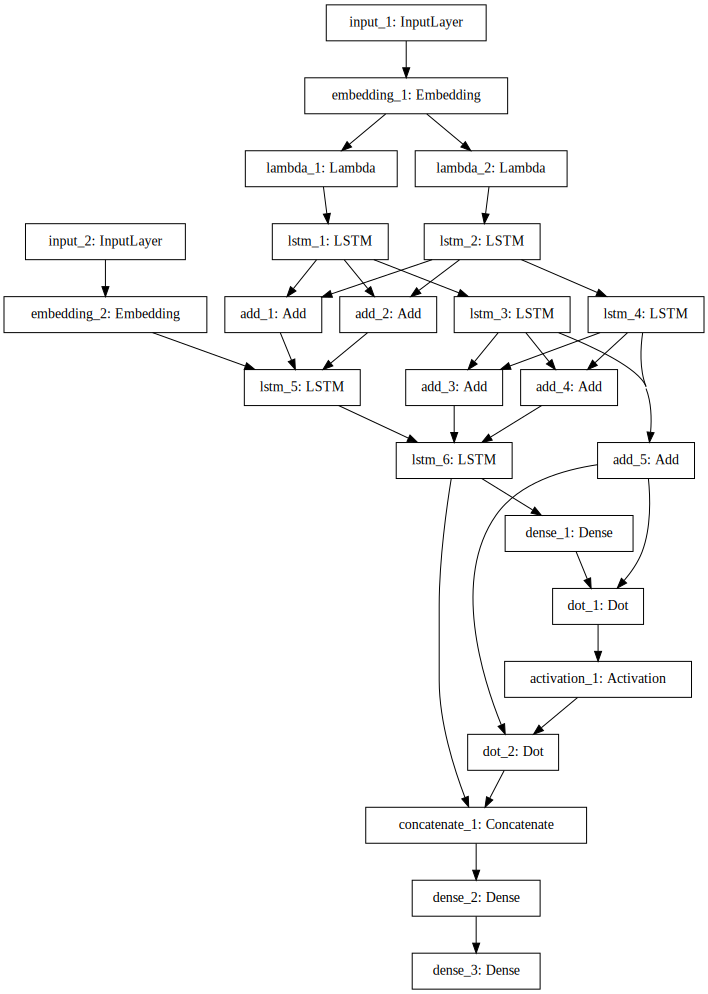

In [157]:
SVG(show_graph(model_generator.model))

In [158]:
class Discriminator(object):
    def __init__(self,
                 dim_input_seq,
                 dim_input_vocab,
                 dim_emb,
                 dim_hid,
                 emb_matrix_input):

        self.dim_input_seq = dim_input_seq
        self.dim_input_vocab = dim_input_vocab
        
        self.dim_emb = dim_emb
        self.dim_hid = dim_hid
        
        self.emb_matrix_input = emb_matrix_input
        
        # Model
        self.model = None
        self.model_embedding = None
        self.model_inference = None
                
        self._num_bidirectional_layers = 2
        
    def embedding(self):
        from keras.layers import Input, Embedding
        
        # Input Layer
        # (dim_input_seq,) 
        inputs = Input(shape=(self.dim_input_seq,), dtype='int32')
        
        # Embedding Layer
        # (dim_input_seq,)->(dim_input_seq, dim_emb)
        embedded_seq = Embedding(self.dim_input_vocab,
                                 self.dim_emb,
                                 weights=[self.emb_matrix_input],
                                 trainable=False)(inputs)
        
        return Model(inputs, embedded_seq)
        
    def inference(self):
        from keras.layers import Input, Dense, LSTM, Activation
        from keras.layers import concatenate, dot, add
        from keras.layers import Lambda
        
        # Input Layer
        # (dim_input_seq, dim_emb)
        inputs = Input(shape=(self.dim_input_seq, self.dim_emb))
        
        seq_fwd = Lambda(lambda x: x)(inputs)
        seq_bwd = Lambda(lambda x: x)(inputs)
        
        # Bidirectional LSTM Layer
        states = []
        for i in range(self._num_bidirectional_layers):
            # (dim_input_seq, dim_emb)->(dim_seq_input, dim_hid)
            seq_fwd, *states_fwd = LSTM(self.dim_hid, return_sequences=True, return_state=True)(seq_fwd)
            
            # (dim_input_seq, dim_emb)->(dim_seq_input, dim_hid)
            seq_bwd, *states_bwd = LSTM(self.dim_hid, return_sequences=True, return_state=True, go_backwards=True)(seq_bwd)
                        
            states.append([add([states_fwd[j], states_bwd[j]]) for j in range(len(states_fwd))])
        
        # Output Layer
        outputs = [Dense(self.dim_hid, activation='relu')(concatenate([vec for vec in state])) for state in states]
        outputs = Dense(self.dim_hid, activation='relu')(concatenate([output for output in outputs]))
        outputs = Dense(self.dim_hid//2, activation='relu')(outputs)
        outputs = Dense(self.dim_hid//4, activation='relu')(outputs)
        outputs = Dense(2, activation='softmax')(outputs)
        
        return Model(inputs, outputs)
    
    def compile(self):
        from keras.layers import Input
        from keras.optimizers import Adam
        
        # Embedding model
        print('Compiling: Embedding model')
        self.model_embedding = self.embedding()
        
        # Inference model
        print('Compiling: Inference model')
        self.model_inference = self.inference()
        
        # Discriminator model
        print('Compiling: Discriminator model')
        inputs = Input(shape=(self.dim_input_seq,)) # (dim_input_seq,)
        inputs_embedded = self.model_embedding(inputs) # (dim_input_seq,)->(dim_input_seq, dim_emb)
        outpus = self.model_inference(inputs_embedded) # (dim_input_seq, dim_emb)->(2)
        
        self.model = Model(inputs, outpus)
        self.model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001))
        
    def set_trainable(self, val):
        self.model_inference.trainable = val
        for l in self.model_inference.layers:
            l.trainable = val

In [159]:
model_discriminator = Discriminator(dim_input_seq=dim_seq['JP'],
                                    dim_input_vocab=dim_vocab['JP'],
                                    dim_emb=dim_emb['JP'],
                                    dim_hid=256,
                                    emb_matrix_input=emb_matrix['JP'])

In [160]:
model_discriminator.compile()

Compiling: Embedding model
Compiling: Inference model
Compiling: Discriminator model


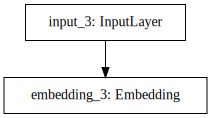

In [161]:
SVG(show_graph(model_discriminator.model_embedding))

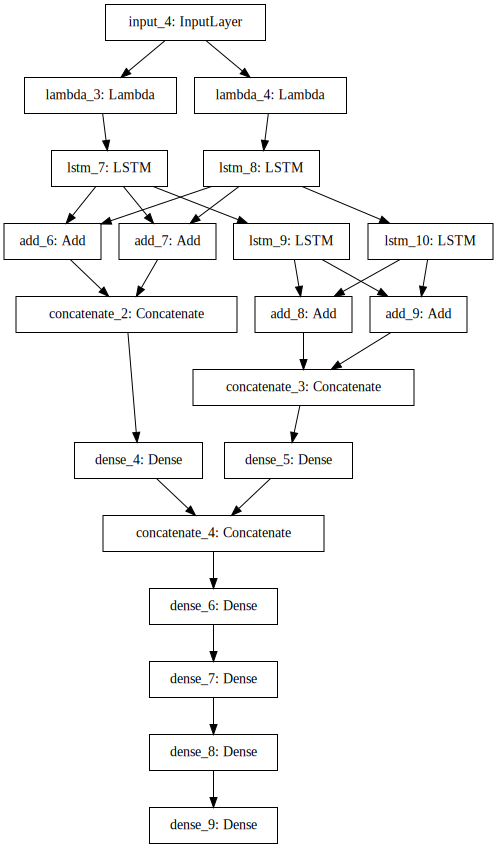

In [162]:
SVG(show_graph(model_discriminator.model_inference))

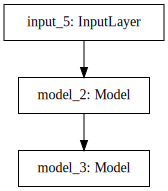

In [163]:
SVG(show_graph(model_discriminator.model))

In [164]:
class GAN(object):
    def __init__(self, generator, discriminator):

        self.generator = generator
        self.discriminator = discriminator
        
    def inference(self):
        from keras.layers import Input
        from keras.layers import dot
        from keras.layers import Lambda
        
        # [(g_dim_input_seq,), (g_dim_output_seq,)]
        inputs_generator = [Input(shape=(dim_input,), dtype='int32') for dim_input in self.generator['dim_input']]
        
        # [(g_dim_input_seq, ), (g_dim_output_seq, )]->(g_dim_output_seq, g_dim_output_vocab)  
        outputs_generator = self.generator['model']([input for input in inputs_generator])
        
        # (d_dim_input_vocab, dim_emb)
        inputs_emb_matrix = Input(tensor=K.constant(self.discriminator['emb_matrix'][np.newaxis]))
        
        #[(d_dim_input_seq, d_dim_input_vocab), (d_dim_input_vocab, dim_emb)]-> (d_dim_input_seq, dim_emb)
        inputs_discriminator = dot([outputs_generator, inputs_emb_matrix], axes=(2,1))
        
        # (d_dim_input_seq, dim_emb)->(2,)
        outputs_discriminator = self.discriminator['model'](inputs_discriminator)

        return Model([inputs_generator[0], inputs_generator[1], inputs_emb_matrix], outputs_discriminator)
    
    def compile(self):
        from keras.optimizers import Adam

        self.model = self.inference()
        self.model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001))

In [165]:
model_GAN = GAN(generator={'model': model_generator.model,
                           'dim_input': [model_generator.dim_input_seq, model_generator.dim_output_seq]},
                discriminator={'model': model_discriminator.model_inference,
                               'emb_matrix': model_discriminator.emb_matrix_input})

In [166]:
model_discriminator.set_trainable(False)
model_GAN.compile()

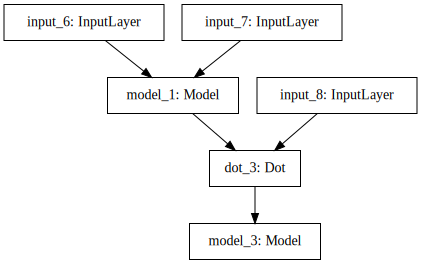

In [167]:
SVG(show_graph(model_GAN.model))

In [168]:
# Training the model

In [169]:
def fit(generator,
        discriminator,
        GAN,
        X_train,
        Y_train,
        epochs,
        batch_size,
        verbose=1):

    num_steps = len(X_train) // batch_size

    for i in range(num_steps):
        print('{0:03d}/{1:03d}'.format(i+1, num_steps))
        
        # Train Discriminator
        discriminator['set_trainable'](True)

        ## Generate input sequences for Generator
        index_batch = np.random.randint(0, X_train.shape[0], size=batch_size)
        inputs_generator_X = X_train[index_batch, :]
        inputs_generator_Y = Y_train[index_batch, :] 

        ## Generate train data for Discriminator
        ## [(batch_size, dim_input_seq,), (batch_size, dim_output_seq)]->(batch_size, dim_output_seq, dim_output_vocab)
        generated_sentences = generator['model'].predict([inputs_generator_X, inputs_generator_Y])
        
        ## (batch_size, dim_output_seq, dim_output_vocab)->(batch_size, dim_output_seq,)
        generated_sentences = [np.argmax(generated_sentences, axis=2)][0]
        
        ## [(batch_size, dim_output_seq,), (batch_size, dim_output_seq,)]->(batch_size*2, dim_output_seq,)
        inputs_discriminator_X = np.concatenate((inputs_generator_Y, generated_sentences))
        
        inputs_discriminator_Y = np.zeros([2*batch_size, 2])
        inputs_discriminator_Y[:batch_size, 1] = 1
        inputs_discriminator_Y[batch_size:, 0] = 1   

        ## Train Discriminator
        print('Training: Discriminator')
        discriminator['model'].train_on_batch(inputs_discriminator_X, inputs_discriminator_Y)

        # Train Generator
        discriminator['set_trainable'](False)

        ## Generate input sequences for Generator
        index_batch = np.random.randint(0, X_train.shape[0], size=batch_size)
        inputs_generator_X = X_train[index_batch, :]
        inputs_generator_Y = Y_train[index_batch, :]

        target = np.zeros([batch_size, 2])
        target[:, 1] = 1
        
        print('Training: GAN')
        GAN['model'].train_on_batch([inputs_generator_X, inputs_generator_Y], target)

In [170]:
fit(generator={'model': model_generator.model},
    discriminator={'model': model_discriminator.model,
                   'set_trainable': model_discriminator.set_trainable},
    GAN={'model': model_GAN.model},
    X_train=data_train['EN'],
    Y_train=data_train['JP'],
    epochs=1,
    batch_size=128)

001/113
Training: Discriminator
Training: GAN


InvalidArgumentError: You must feed a value for placeholder tensor 'input_1' with dtype float and shape [?,55]
	 [[Node: input_1 = Placeholder[dtype=DT_FLOAT, shape=[?,55], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: loss_1/mul/_443 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_17048_loss_1/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'input_1', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2856, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-156-65c0d7cb539a>", line 1, in <module>
    model_generator.compile()
  File "<ipython-input-154-37f623b96f0e>", line 141, in compile
    self.model = self.inference()
  File "<ipython-input-154-37f623b96f0e>", line 63, in inference
    self._encoder_inputs = Input(shape=(self.dim_input_seq,))
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/topology.py", line 1439, in Input
    input_tensor=tensor)
  File "/usr/local/lib/python3.5/dist-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/topology.py", line 1348, in __init__
    name=self.name)
  File "/usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py", line 497, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/array_ops.py", line 1599, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 3091, in _placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_1' with dtype float and shape [?,55]
	 [[Node: input_1 = Placeholder[dtype=DT_FLOAT, shape=[?,55], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: loss_1/mul/_443 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_17048_loss_1/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
